In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Linear regression from scratch

In [138]:
class MyLinearRegression():
    def __init__(self, solver="analytical", regularization=False, lambda_=0.05, alpha=0.01, n_iter=1000):
        if solver not in ["analytical", "grad_descent"]:
            raise ValueError('Incorrect solver inputted. Choose either "analytical" or "grad_descent".')
        self._w = None
        self._solver = solver
        self._regularization = regularization     # Whether to apply L2 regularization
        self._lambda_ = lambda_
        self._alpha = alpha
        self._n_iter = n_iter

    def fit(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        if y.ndim > 2:
            raise ValueError("Target y has the wrong shape %s" % str(y.shape))

        ones = np.ones((len(y), 1))
        X = np.hstack((ones, X))

        if self._regularization:
            if self._solver == "analytical":
                X_T = X.T
                I = np.identity(X.shape[1])
                I[0, 0] = 0  # Exclude intercept from regularization
                self._w = np.linalg.pinv(X_T @ X + self._lambda_ * I) @ X_T @ y
            else:
                self._w = np.zeros((X.shape[1], 1))

                for _ in range(self._n_iter):
                    y_pred = X @ self._w
                    reg_term = self._lambda_ * self._w
                    reg_term[0] = 0  # Exclude intercept from regularization
                    grad = X.T @ (y_pred - y) / len(y) + reg_term
                    self._w -= self._alpha * grad
        else:
            if self._solver == "analytical":
                X_T = X.T
                self._w = np.linalg.pinv(X_T @ X) @ X_T @ y
            else:
                self._w = np.zeros((X.shape[1], 1))

                for _ in range(self._n_iter):
                    y_pred = X @ self._w
                    grad = 2 * X.T @ (y_pred - y) / len(y)
                    self._w -= self._alpha * grad


    def predict(self, X):
        ones = np.ones((X.shape[0], 1))
        X = np.hstack((ones, X))
        return X @ self._w

    def score(self, X, y):
        if y.ndim == 1:
            y = y.reshape(-1, 1)
        if y.ndim > 2:
            raise ValueError("Target y has the wrong shape %s" % str(y.shape))
        y_pred = self.predict(X)
        score = 1 - (((y - y_pred) ** 2).sum() / ((y - y.mean()) ** 2).sum())
        return score

    def get_weights(self):
        return self._w

# Generate dataset

In [139]:
X, y = make_regression(
    n_samples=1200,
    n_features=12,
    noise=10,
    random_state=42
)

# Creating models

In [140]:
model_no_reg_analyt = MyLinearRegression()
model_reg_grad_descent = MyLinearRegression(regularization=True, solver="grad_descent")
lin_reg = LinearRegression()
ridge_reg = Ridge()

In [141]:
scaler = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

### Compare models

In [142]:
model_no_reg_analyt.fit(X_train_normalized, y_train)
model_reg_grad_descent.fit(X_train_normalized, y_train)
lin_reg.fit(X_train_normalized, y_train)
ridge_reg.fit(X_train_normalized, y_train)

Ridge()

In [132]:
y_pred1 = model_no_reg_analyt.predict(X_test_normalized)
y_pred2 = model_reg_grad_descent.predict(X_test_normalized)
y_pred3 = lin_reg.predict(X_test_normalized)
y_pred4 = ridge_reg.predict(X_test_normalized)

In [133]:
predictions_dict = {"model_no_reg_analyt": y_pred1.flatten(),
                   "model_reg_grad_descent": y_pred2.flatten(),
                   "lin_reg": y_pred3.flatten(),
                   "ridge_reg": y_pred4.flatten()}
df = pd.DataFrame(predictions_dict)
df

,model_no_reg_analyt,model_reg_grad_descent,lin_reg,ridge_reg
0,198.444236,188.839583,198.444236,198.234379
1,122.658368,116.221038,122.658368,122.517243
2,-181.820755,-171.159726,-181.820755,-181.585783
3,44.786650,41.826251,44.786650,44.721295
4,140.038267,131.793082,140.038267,139.856722
...,...,...,...,...
235,-339.288021,-321.298338,-339.288021,-338.893114
236,137.423259,130.215041,137.423259,137.265249
237,-14.400788,-16.138497,-14.400788,-14.441038
238,54.318510,51.202763,54.318510,54.250049


In [143]:
score1 = model_no_reg_analyt.score(X_test_normalized, y_test)
score2 = model_reg_grad_descent.score(X_test_normalized, y_test)
score3 = lin_reg.score(X_test_normalized, y_test)
score4 = ridge_reg.score(X_test_normalized, y_test)

score_dict = {"Custom linear regression with analytical solution": score1,
             "Custom linear regression with gradient descent approach and regularization": score2,
             "Linear regression with analytical solution from sklearn": score3,
             "Ridge regression with analytical solution from sklearn": score4}

In [144]:
i = 1
for key, value in zip(score_dict.keys(), score_dict.values()):
    print("{}. {} score: {}".format(i, key, value))
    i+=1

1. Custom linear regression with analytical solution score: 0.9957434820042868
2. Custom linear regression with gradient descent approach and regularization score: 0.9930200575878594
3. Linear regression with analytical solution from sklearn score: 0.9957434820042868
4. Ridge regression with analytical solution from sklearn score: 0.9957402855256093


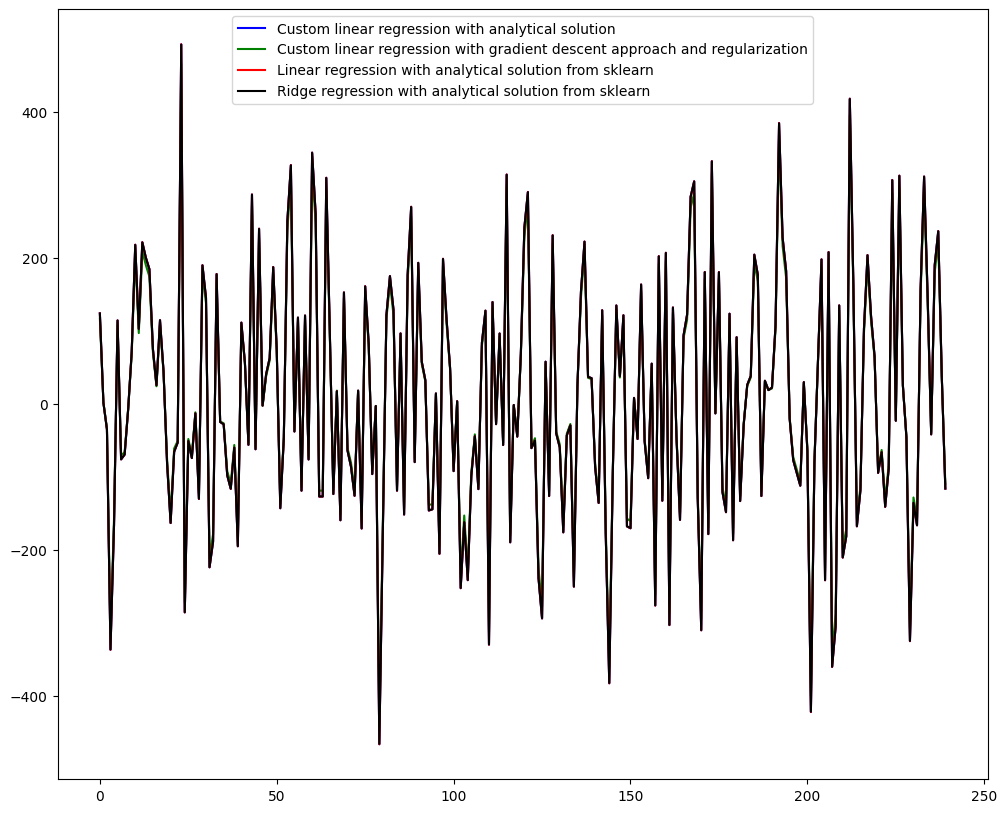

In [85]:
fig, ax = plt.subplots(figsize=(12, 10))
plt.plot([x for x in range(len(y_pred1))], y_pred1, color="b", label="Custom linear regression with analytical solution")
plt.plot([x for x in range(len(y_pred2))], y_pred2, color="g", label="Custom linear regression with gradient descent approach and regularization")
plt.plot([x for x in range(len(y_pred3))], y_pred3, color="r", label="Linear regression with analytical solution from sklearn")
plt.plot([x for x in range(len(y_pred4))], y_pred4, color="k", label="Ridge regression with analytical solution from sklearn")
plt.legend()
plt.show()